# Titanic data clean up and building a prediction model.

In [660]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [661]:
df = pd.read_csv('titanic.csv')
# drop rows with all NaN values
df = df.dropna(axis=0, how='all')

In [662]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Feature engineering

First off we'll check how having a different pclass is going to affect your survival rate

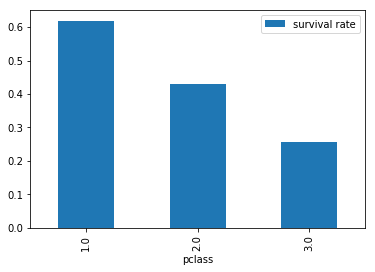

In [663]:
pc = df[['pclass', 'survived']].groupby('pclass').mean()
ax = pc.plot(kind='bar')
ax.legend(['survival rate'])

As we can see above the higher the pclass the higher your survival rate, so we're going to keep this feature for our prediction model.

Next let's move on to sex.

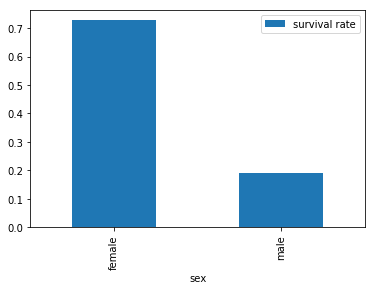

In [664]:
gd = df[['sex', 'survived']].groupby('sex').mean()
ax = gd.plot(kind='bar')
ax.legend(['survival rate'])

As we can see gender plays a great role in survival rate.

For convinience let's construct new columns with binarized values

In [665]:
df = pd.get_dummies(df, columns=['sex'])
df[['sex_female', 'sex_male']].head(5)

,sex_female,sex_male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


Now we're moving to age. 

We're going to make two new features:
<ul>
    <li>Custom cut with groups as follows: (0-4), (4-18), (18-55) and 55+</li>
    <li>Normal qcut which will evenly distribute all rows to 4 groups (picked by qcut)</li>
</ul>

Later we're going to see which feature will yield better results.

For starters let's fill all NaN values with mean

In [666]:
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)

In [667]:
df['age1'] = pd.cut(df.age, [-np.inf, 4, 18, 55, np.inf], labels=range(1, 5))
df['age2'] = pd.qcut(df.age, 4, labels=range(1, 5))
df[['age1', 'age2']].head(5)

,age1,age2
0,3,2
1,1,1
2,1,1
3,3,3
4,3,2


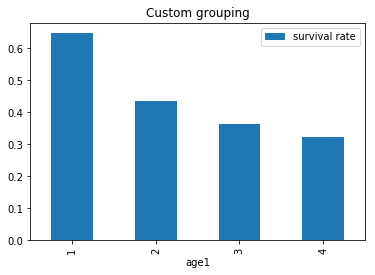

In [668]:
age1 = df[['age1', 'survived']].groupby('age1').mean()
ax = age1.plot(kind='bar')
ax.set_title('Custom grouping')
ax.legend(['survival rate'])

We can see that the survival rate for infants is the highest and is decreasing as the age goes up.

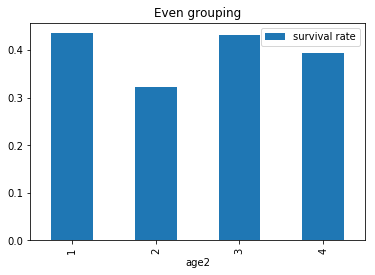

In [669]:
age2 = df[['age2', 'survived']].groupby('age2').mean()
ax = age2.plot(kind='bar')
ax.set_title('Even grouping')
ax.legend(['survival rate'])

This kind of grouping doesn't really tell us anything. For example infants with the highest survival rate are thrown with teenagers and middle aged people.

Now we're going to combine 2 features: sibsp + parch. This new feature is going to represent size of the family.

In [670]:
df['family'] = df['sibsp'] + df['parch']
df[['sibsp', 'parch', 'family']].head(5)

,sibsp,parch,family
0,0.0,0.0,0.0
1,1.0,2.0,3.0
2,1.0,2.0,3.0
3,1.0,2.0,3.0
4,1.0,2.0,3.0


And let's see how the size of the family is going to affect survival rate

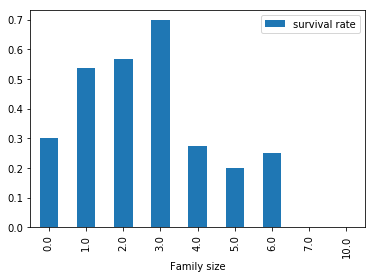

In [671]:
f = df[['family', 'survived']].groupby('family').mean()
ax = f.plot(kind='bar')
ax.set_xlabel('Family size')
ax.legend(['survival rate'])

The survival rate is going up till it gets to 3. Later drop may be caused by for example searching for the members of the family on the ship and as a result not making it in time to a boat. We don't know but it's one of the many scenarios we could think of, but that's not really important. From this diagram we can conclude that families with size of 1-3 have the highest chance of survival and that's enough to include it in our prediction model. 

Now we're moving on to fare values. First we're groing to clean up data a little bit and fill in the missing values. Here's our plan for this:
<ul>
    <li>replace all NaN values with 0</li>
    <li>find mean and standard deviation for all pclasses </li>
    <li>for all rows where the fare equals 0, set fare value to according pclass mean + rand(-std, std)</li>
</ul>


In [672]:
df['fare'] = df['fare'].fillna(0)
pclass_fare = df[['pclass', 'fare']].pivot(columns='pclass', values='fare')
pclass_fare.sample(5)

pclass,1.0,2.0,3.0
209,57.7500,NaN,NaN
829,NaN,NaN,46.9
138,153.4625,NaN,NaN
78,83.1583,NaN,NaN
735,NaN,NaN,15.9


In [673]:
mean = pclass_fare.mean(axis=0, skipna=True)
mean

pclass
1.0    87.508992
2.0    21.179196
3.0    13.284126
dtype: float64

In [674]:
std = pclass_fare.std(axis=0, skipna=True)
std

pclass
1.0    80.447178
2.0    13.607122
3.0    11.497098
dtype: float64

In [675]:
from random import randrange

def fill_fare_value(row ,mean, std):
    if row['pclass'] == 1:
        return mean[1] + randrange(-std[1], std[1]) 
    elif row['pclass'] == 2:
        return mean[2] + randrange(-std[2], std[2])
    elif row['pclass'] == 3:
        return mean[3] + randrange(-std[3], std[3])
    
df.loc[df['fare'] == 0, 'fare'] = df[df['fare'] == 0].apply(
    lambda row: fill_fare_value(row, mean.astype(int), std.astype(int)),
    axis=1
)

# final check to see if we got rid of all 0 values
print('Number of rows where fare is zero:', len(df[df['fare'] == 0]))

Number of rows where fare is zero: 0


After cleaning let's see how different group sizes are going to affect survival rate.

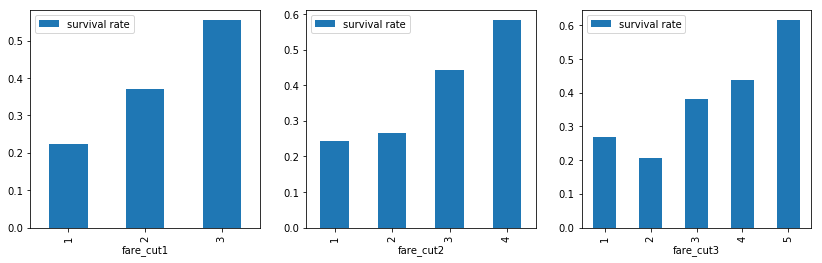

In [676]:
cut1 = pd.qcut(df['fare'], 3, labels=range(1, 4))
cut2 = pd.qcut(df['fare'], 4, labels=range(1, 5))
cut3 = pd.qcut(df['fare'], 5, labels=range(1, 6))

qcut = df

qcut['fare_cut1'] = cut1
qcut['fare_cut2'] = cut2
qcut['fare_cut3'] = cut3

qcut1 = qcut[['fare_cut1', 'survived']].groupby('fare_cut1').mean()
qcut2 = qcut[['fare_cut2', 'survived']].groupby('fare_cut2').mean()
qcut3 = qcut[['fare_cut3', 'survived']].groupby('fare_cut3').mean()

fig, axes = plt.subplots(nrows=1, ncols=3)
plots = [
    qcut1.plot(kind='bar', ax=axes[0], figsize=(14,4)),
    qcut2.plot(kind='bar', ax=axes[1]),
    qcut3.plot(kind='bar', ax=axes[2])
]
[i.legend(['survival rate']) for i in plots]

Regardless of the number of groups we have there is a trend of: the more you paid for your ticket, the higher your survival rate

Now let's look at the embarked feature

First let's fill NaN with most common value

In [677]:
e = df['embarked'].value_counts().idxmax()
df['embarked'] = df['embarked'].fillna(e)

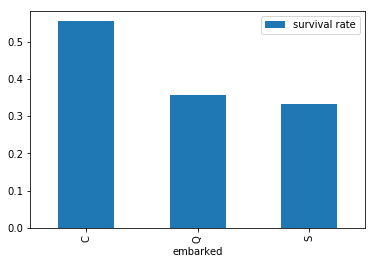

In [678]:
e = df[['embarked', 'survived']].groupby('embarked').mean()
ax = e.plot(kind='bar')
ax.legend(['survival rate'])

There's clearly a distinction between different values of embarked, so we're gonna add this feature to our model.

Also we're going to replace values S: 1, Q: 2, C: 3.

In [679]:
df = pd.get_dummies(df, columns=['embarked'])

There is one more feature that we should look at. Specifically saying it's a title that is hidden in the name feature that we're going to extract.

In [680]:
df['title'] = df['name'].str.extract(',.* ([A-Za-z]+)\.', expand=False)
df[['name', 'title']].sample(5)

,name,title
1138,"Reed, Mr. James George",Mr
516,"Navratil, Mr. Michel (""Louis M Hoffman"")",Mr
414,"Gale, Mr. Shadrach",Mr
787,"Eklund, Mr. Hans Linus",Mr
267,"Smith, Mr. James Clinch",Mr


Now let's see our titles

In [681]:
titles = df.groupby('title').size().sort_values(ascending=False)
titles

title
Mr          757
Miss        260
Mrs         196
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Countess      1
Don           1
Dona          1
Sir           1
Jonkheer      1
L             1
Lady          1
Mme           1
Capt          1
dtype: int64

We're going to substitute all the values that appeared less than eight times and then see how titles affect survival rate:

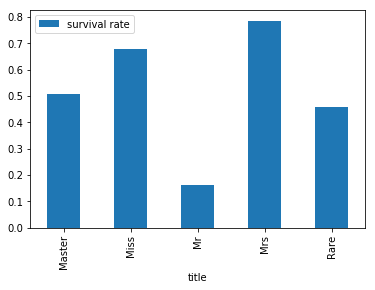

In [682]:
titles_low_count = list(titles[titles <= 8].index.values)
df['title'] = df['title'].apply(
    lambda x: 'Rare' if x in titles_low_count else x
)

t = df[['title', 'survived']].groupby('title').mean()
ax = t.plot(kind='bar')
ax.legend(['survival rate'])

It was easy to guess that titles occupied by women will have the highest survival rate and titles solely occupied by men the lowest. Something interesting may be that women that are married have slightly higher survival rate than the ones that are not.

In [683]:
df[['name', 'title']].sample(5)

,name,title
938,"Klasen, Mr. Klas Albin",Mr
54,"Carter, Master. William Thornton II",Master
1208,"Skoog, Miss. Mabel",Miss
855,"Hassan, Mr. Houssein G N",Mr
1219,"Spector, Mr. Woolf",Mr


We've arrived to a point that we can collect all the features that we've been working on and start building a prediction model, here's what we've got so far:

In [684]:
df = pd.get_dummies(df, columns=['pclass', 'title'])
df=df.rename(columns = {'pclass_1.0':'pclass_1', 'pclass_2.0': 'pclass_2', 'pclass_3.0': 'pclass_3'})

In [685]:
prediction_model = df[['fare','age','family', 'pclass_1', 'pclass_2', 'pclass_3',
                       'sex_female','sex_male', 'embarked_C', 'embarked_Q', 
                       'embarked_S', 'title_Mr', 'title_Miss',
                       'title_Mrs', 'title_Master', 'title_Rare',
                       'survived']]
prediction_model.sample(5)

,fare,age,family,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Mr,title_Miss,title_Mrs,title_Master,title_Rare,survived
908,9.8250,21.000000,1.0,0,0,1,1,0,0,0,1,0,1,0,0,0,0.0
65,53.1000,33.000000,1.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1.0
358,13.0000,42.000000,0.0,0,1,0,1,0,0,0,1,0,0,1,0,0,1.0
1029,24.1500,29.881135,1.0,0,0,1,0,1,0,1,0,1,0,0,0,0,0.0
634,7.8958,26.000000,0.0,0,0,1,0,1,0,0,1,1,0,0,0,0,0.0


Let's also do a sanity check for the NaN values

In [686]:
print('NaN rows:', len(prediction_model[prediction_model.isnull().any(axis=1)]))

NaN rows: 0
